In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import math

In [2]:
# Work stuff

cov_mat = [[116.92, 29.86, 6.53, 18.65, 19.4, 37.33, 19.91],
           [29.86, 83.61, 14.1, 15.09, 19.68, 31.51, 15.89],
           [6.53, 14.1, 67.5, 4.73, 18.33, 15.62, 16.78],
           [18.65, 15.09, 4.73, 106.8, 21.76, 29.36, 23.7],
           [19.4, 19.68, 18.33, 21.76, 92.98, 29.35, 28.44],
           [37.33, 31.51,16.62,29.36,29.35, 100.9, -2.88],
           [19.91, 15.89, 16.78, 23.7, 28.44, -2.88, 117.1]]

cov_mat2 = np.zeros((7,7))

for i in range(7):
    for j in range(7):
        cov_mat2[i][j]=cov_mat[i][j]

eig_val, eig_vec = np.linalg.eig(cov_mat2)
print(eig_val)
eig_val = np.array(list(map(lambda x: 1/math.sqrt(x), eig_val)))
idt = np.identity(7) * eig_val

np.matmul(idt, eig_vec.transpose())

[223.18235202 119.20505408  92.90052498  84.60736122  46.99136115
  63.8735557   55.04979085]


array([[-0.03148117, -0.02380116, -0.01281203, -0.02572857, -0.02613941,
        -0.02938383, -0.0234584 ],
       [-0.02680544, -0.01309677,  0.00938203,  0.00865518,  0.01432281,
        -0.04325457,  0.07252457],
       [-0.06015448, -0.01711274, -0.00378899,  0.07501925,  0.01388029,
         0.02111854, -0.02391432],
       [ 0.04955453, -0.02007565, -0.05041133,  0.05418049, -0.05330552,
        -0.02302833,  0.01058343],
       [-0.0328376 , -0.03008865, -0.05475299, -0.0383056 , -0.0344575 ,
         0.10004929,  0.06028667],
       [ 0.03427444, -0.08658491, -0.02752525, -0.01177488,  0.07673108,
        -0.0010989 , -0.01411006],
       [-0.01776102,  0.07109156, -0.09545713, -0.00637863,  0.05182959,
        -0.02947672, -0.00937959]])

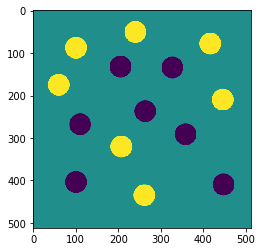

In [14]:
img = cv2.imread('EX_2_data/EX_2_data/test_blob_uniform.png.', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img)
plt.show()

In [197]:
sigma = 25
t1 = sigma**2/2 # scale space
ker_width1 = math.ceil(2*3*t1)

t2 = sigma**2/2 # filter
ker_width2 = math.ceil(2*3*t2)

def gaussianDens(x, m, s):
    r = np.exp(-(x-m)**2/(2*s))/(math.sqrt(s*2*math.pi))
    return r

def gaussian2derivative(x, s):
    r = np.exp(-x**2/(2*s))/(math.sqrt(s*2*math.pi)) * (x**2/s**2 - 1/s)
    return r

def gaussianKernelMaker_1d(ker_w1, t1, ker_w2, t2):
    coord1 = np.array(range(ker_w1+1))-(ker_w1/2)
    coord2 = np.array(range(ker_w2+1))-(ker_w2/2)
    
    ker1 = np.array(list((map(lambda x: gaussianDens(x, 0, t1), coord1))))
    ker_derivative2 = np.array(list((map(lambda x: gaussian2derivative(x, t2), coord2))))
    
    return(np.array([ker1]), np.array([ker_derivative2]))

ker, ker2der = gaussianKernelMaker_1d(ker_width1, t1, ker_width2, t2)

#print(ker)
#print(ker2der)

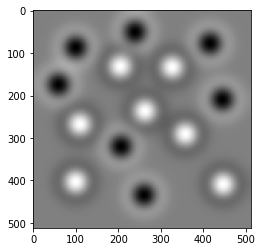

Min:  -0.30136069360443574
Max:  0.2990335756159318


In [198]:
conv_img = img

conv_img_x = scipy.ndimage.convolve(conv_img, ker)
conv_img_x = scipy.ndimage.convolve(conv_img_x, ker2der.transpose())

conv_img_y = scipy.ndimage.convolve(conv_img, ker.transpose())
conv_img_y = scipy.ndimage.convolve(conv_img_y, ker2der)

conv_img = conv_img_y + conv_img_x

plt.imshow(conv_img, cmap = "gray")
plt.show()

print("Min: ", min(map(lambda x: min(x), conv_img)))
print("Max: ", max(map(lambda x: max(x), conv_img)))

## Task 2
Blob detection

In [189]:
print("A scale of: ", t1, " has been chosen")

A scale of:  312.5  has been chosen


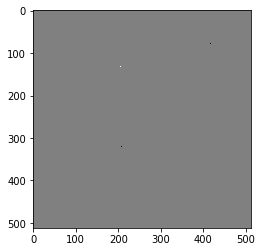

In [215]:

avg_value = np.average(conv_img)
s = len(conv_img)
padded_img = np.ones((s+2, s+2))*avg_value
padded_img[1:-1,1:-1] = conv_img

def blobDetecter(img):
    s = len(img)-2
    img_new = np.zeros((s, s))
    th=0.06
    for i in range(s):
        i = i+1
        for j in range(s):
            j = j+1
            lst = [img[i-1][j], img[i+1][j], img[i][j-1], img[i][j+1], img[i-1][j-1], img[i-1][j+1], img[i+1][j-1], img[i+1][j+1]]
            if img[i][j] <= min(lst) and img[i][j] < -th:
                img_new[i-1][j-1] = -1
            elif img[i][j] >= max(lst) and img[i][j] > th:
                img_new[i-1][j-1] = 1
            else:
                img_new[i-1][j-1] = 0
    return(img_new)


new_img = blobDetecter(padded_img)
plt.imshow(new_img, cmap = "gray")
plt.show()